# Analyzing Online Behavior for Public Health
### Project 3 - Joseph Okeno-Storms (djm7rd)

---
### Environment Setup

In [1]:
# Install Packages
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install beautifulsoup4

In [2]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import glob
from bs4 import BeautifulSoup
import datetime

---
### Oura Data Preparation


In [6]:
# Load Oura CSV data
oura_data = pd.read_csv('oura_2025-01-20_2025-04-20_trends.csv')
print(oura_data.columns)

Index(['date', 'Previous Night Score', 'Light Sleep Duration', 'Average MET',
       'Sleep Balance Score', 'Sleep Efficiency', 'Total Burn',
       'Bedtime Start', 'Restless Sleep', 'Total Bedtime ', 'REM Sleep Score',
       'Sleep Timing', 'Temperature Score', 'Medium Activity Time',
       'Deep Sleep Score', 'Inactive Time', 'Readiness Score',
       'Deep Sleep Duration', 'Sleep Score', 'Sleep Timin Score',
       'Non-wear Time', 'Move Every Hour Score', 'Sleep Latency',
       'Temperature Trend Deviation', 'Activity Score',
       'Temperature Deviation (°C)', 'Previous Day Activity Score',
       'REM Sleep Duration', 'Resting Heart Rate Score',
       'Total Sleep Duration', 'Average Resting Heart Rate', 'Steps',
       'Awake Time', 'Rest Time', 'Bedtime End', 'Respiratory Rate',
       'Training Frequency Score', 'Activity Burn', 'Sleep Latency Score',
       'Low Activity Time', 'Activity Balance Score', 'High Activity Time',
       'Equivalent Walking Distance', 'Total 

In [89]:
# Calculate Sleep Score
def calculate_stress_score(row, min_max_dict):
    def normalize(val, col):
        min_val, max_val = min_max_dict[col]
        if pd.isna(val):
            return 0.5  # fallback default
        return max(0, min(1, (val - min_val) / (max_val - min_val)))

    norm = {col: normalize(row[col], col) for col in min_max_dict}

    # Factors normalized between 0–1, where higher = more stress
    sleep_factor = (
        0.2 * (1 - norm['Sleep Score']) +
        0.2 * (1 - norm['Deep Sleep Duration']) +
        0.2 * (1 - norm['REM Sleep Duration']) +
        0.2 * (1 - norm['Sleep Efficiency']) +
        0.2 * (1 - norm['Restfulness Score'])
    )

    activity_factor = (
        0.25 * norm['Inactive Time'] +
        0.25 * norm['Low Activity Time'] +
        0.25 * norm['High Activity Time'] -
        0.25 * norm['Steps']  # more steps = less stress
    )

    physiological_factor = (
        0.3 * norm['Average Resting Heart Rate'] +
        0.3 * norm['Temperature Deviation (°C)'] +
        0.2 * norm['Respiratory Rate'] +
        0.2 * (1 - norm['Average HRV'])  # high HRV = less stress
    )

    recovery_factor = (
        0.25 * (1 - norm['Readiness Score']) +
        0.25 * (1 - norm['Recovery Index Score']) +
        0.2 * (1 - norm['HRV Balance Score']) +
        0.15 * norm['Sleep Latency'] +
        0.15 * (1 - norm['Sleep Timin Score'])
    )

    raw_score = (
        0.25 * sleep_factor +
        0.25 * activity_factor +
        0.25 * physiological_factor +
        0.25 * recovery_factor
    )

    return float(round(60 + (100 - 60) * raw_score, 2))

In [91]:
selected_columns = [
    'Sleep Score', 'Deep Sleep Duration', 'REM Sleep Duration', 'Sleep Efficiency', 'Restfulness Score',
    'Inactive Time', 'Low Activity Time', 'High Activity Time', 'Steps', 'Total Burn',
    'Average Resting Heart Rate', 'Temperature Deviation (°C)', 'Respiratory Rate', 'Average HRV',
    'Readiness Score', 'Recovery Index Score', 'HRV Balance Score', 'Sleep Latency', 'Sleep Timin Score'
]

selected_features_df = oura_data[selected_columns]
min_max_dict = {col: (selected_features_df[col].min(), selected_features_df[col].max()) for col in selected_features_df.columns}

oura_data['Stress Score'] = oura_data.apply(lambda row: calculate_stress_score(row, min_max_dict), axis=1)


In [94]:
# Extract Key Features from data
oura_data = oura_data[[
    'date',
    'Average HRV',
    'Average Resting Heart Rate',
    'Lowest Resting Heart Rate',
    'Stress Score',
]]

# Convert Timestamps to date format
oura_data['date'] = pd.to_datetime(oura_data['date'])

# Add a person column
oura_data.loc[:, 'person'] = 'Joseph'

# Drop NA's
oura_data = oura_data.dropna()

# Reorder DF
oura_data = oura_data[[
    'person',
    'date',
    'Average HRV',
    'Average Resting Heart Rate',
    'Lowest Resting Heart Rate',
    'Stress Score'
]]


# Check data types and missing values
print(oura_data.info())
print(oura_data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 0 to 89
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   person                      90 non-null     object        
 1   date                        90 non-null     datetime64[ns]
 2   Average HRV                 90 non-null     float64       
 3   Average Resting Heart Rate  90 non-null     float64       
 4   Lowest Resting Heart Rate   90 non-null     float64       
 5   Stress Score                90 non-null     float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 4.9+ KB
None
   person       date  Average HRV  Average Resting Heart Rate  \
0  Joseph 2025-01-20         28.0                       66.00   
1  Joseph 2025-01-21         22.0                       69.66   
2  Joseph 2025-01-22         35.0                       67.06   
3  Joseph 2025-01-23         32.0                      

<ipython-input-94-96ef6ba23576>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oura_data['date'] = pd.to_datetime(oura_data['date'])


In [95]:
# Save Oura Data to file
oura_data.to_csv('joseph_processed_oura_data_proj3.csv', index=False)

### Oura Data Visualization

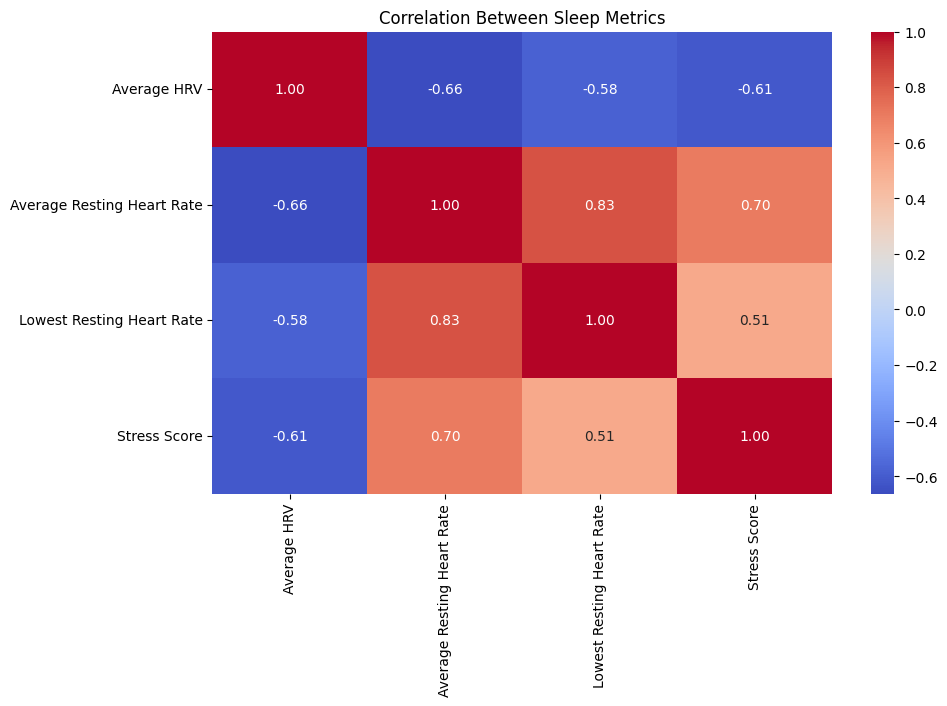

In [97]:
# Plot Correlation matrix of sleep metrics
plt.figure(figsize=(10,6))
# Select only numeric columns for correlation
numeric_oura_data = oura_data.select_dtypes(include=[np.number])
sns.heatmap(numeric_oura_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Sleep Metrics")
plt.show()

---
### Google Takeout Data Preparation

In [99]:
# Mount Google Drive
drive.mount('/content/drive/')

# Define the root directory where your data is stored
root_dir = "/content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/TakeOutProj3/My Activity"

# Find all HTML files in subdirectories
html_files = glob.glob(os.path.join(root_dir, '**', '*.html'), recursive=True)

# Check the number of files found
print(f"Found {len(html_files)} HTML files.")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Found 26 HTML files.


In [100]:
# Extract activity data from an HTML file
def extract_google_activity(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "html.parser")

    activities = []

    # Find all content cells containing activity
    for content_cell in soup.find_all("div", class_="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1"):
        text = content_cell.get_text(separator=" ").strip()

        # Split based on the timestamp format
        parts = text.rsplit(" ", 5)  # Split last 5 words (to separate date/time from activity)

        if len(parts) < 6:
            continue  # Skip if the structure is incorrect

        activity = " ".join(parts[:-5])  # Everything before the last 5 words is the activity
        timestamp = " ".join(parts[-5:])  # The last 5 words form the timestamp
        activities.append((activity, timestamp))

    return activities

# Extract activity data from all HTML files
all_activities = []
for file in html_files:
    print(f"Processing {file}...")
    all_activities.extend(extract_google_activity(file))
    print(f"Length of All Activities: {len(all_activities)}")

# Convert to DataFrame
google_activity_df = pd.DataFrame(all_activities, columns=["Activity", "Timestamp"])
print(f"Length of Google Activity DataFrame: {len(google_activity_df)}")

# Convert timestamp to datetime format
google_activity_df["Timestamp"] = pd.to_datetime(google_activity_df["Timestamp"], errors="coerce")

# Split date and time
google_activity_df["Date"] = google_activity_df["Timestamp"].dt.date
google_activity_df["Time"] = google_activity_df["Timestamp"].dt.time

# Drop rows where conversion failed
google_activity_df.dropna(inplace=True)

# Display the first few rows
print(google_activity_df.head())

Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/TakeOutProj3/My Activity/Assistant/MyActivity.html...
Length of All Activities: 12542
Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/TakeOutProj3/My Activity/Image Search/MyActivity.html...
Length of All Activities: 19274
Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/TakeOutProj3/My Activity/YouTube/MyActivity.html...
Length of All Activities: 19703
Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/TakeOutProj3/My Activity/Developers/MyActivity.html...
Length of All Activities: 19723
Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/TakeOutProj3/My Activity/My Ad Center/MyActivity.html...
Length of All Activities: 19727
Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/TakeOutProj3/My Activity/Help/MyActivity.ht

Streaming output truncated to the last 5000 lines.
<ipython-input-100-f6d8477d105e>:36: FutureWarning: Parsed string "Jul 8, 2020, 2:47:26 PM EDT" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  google_activity_df["Timestamp"] = pd.to_datetime(google_activity_df["Timestamp"], errors="coerce")
<ipython-input-100-f6d8477d105e>:36: FutureWarning: Parsed string "Jul 8, 2020, 2:46:58 PM EDT" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  google_activity_df["Timestamp"] = pd.to_datetime(google_activity_df["Timestamp"], errors="coerce")
<ipython-input-100-f6d8477d105e>:36: FutureWarning: Parsed string "Jul 8, 2020, 2:46:54 PM ED

                Activity           Timestamp        Date      Time
0         Used Assistant 2025-04-22 18:22:40  2025-04-22  18:22:40
1  Used Google Assistant 2025-04-22 18:22:40  2025-04-22  18:22:40
2  Used Google Assistant 2025-04-22 18:22:39  2025-04-22  18:22:39
3         Used Assistant 2025-04-22 18:22:39  2025-04-22  18:22:39
4         Said  I'm back 2025-04-22 18:22:38  2025-04-22  18:22:38


In [101]:
# Save df to csv
google_activity_df.to_csv('joseph_raw_google_activity_proj3.csv', index=False)

In [104]:
# New DF
grouped_google_activity_df = google_activity_df.groupby('Date').agg(
    Activity_Count=('Time', 'count'),
    First_Activity_Time=('Time', 'min'),
    Last_Activity_Time=('Time', 'max')
).reset_index()

print(grouped_google_activity_df.head())

         Date  Activity_Count First_Activity_Time Last_Activity_Time
0  2014-03-07               1            19:49:34           19:49:34
1  2014-04-08               2            20:26:54           20:32:09
2  2014-05-05               1            20:53:23           20:53:23
3  2014-06-03               1            23:33:57           23:33:57
4  2014-10-23               1            20:24:06           20:24:06


In [107]:
# Define start and end date
start_date = pd.Timestamp("2025-1-20")
end_date = pd.Timestamp("2025-04-20")

# Convert the 'Date' column to datetime if not already
grouped_google_activity_df["Date"] = pd.to_datetime(grouped_google_activity_df["Date"])

# Filter the DataFrame for the specified date range
filtered_google_activity = grouped_google_activity_df[(grouped_google_activity_df["Date"] >= start_date) & (grouped_google_activity_df["Date"] <= end_date)]

# Add Column
filtered_google_activity["Person"] = "Joseph"

# Reorder Dataframe
filtered_google_activity = filtered_google_activity[["Person", "Date", "Activity_Count", "First_Activity_Time", "Last_Activity_Time"]]

# Display the first few rows to verify
print(filtered_google_activity.head())

# Save filtered google data to csv
filtered_google_activity.to_csv('joseph_cleaned_google_activity_proj3.csv', index=False)

      Person       Date  Activity_Count First_Activity_Time Last_Activity_Time
2934  Joseph 2025-01-20             147            07:44:34           23:59:58
2935  Joseph 2025-01-21             193            00:00:00           23:59:39
2936  Joseph 2025-01-22             270            00:05:38           23:41:41
2937  Joseph 2025-01-23             138            00:34:14           23:57:50
2938  Joseph 2025-01-24             251            00:50:40           21:59:40


<ipython-input-107-d4d9225052aa>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_google_activity["Person"] = "Joseph"


### Google Takeout Data Analysis

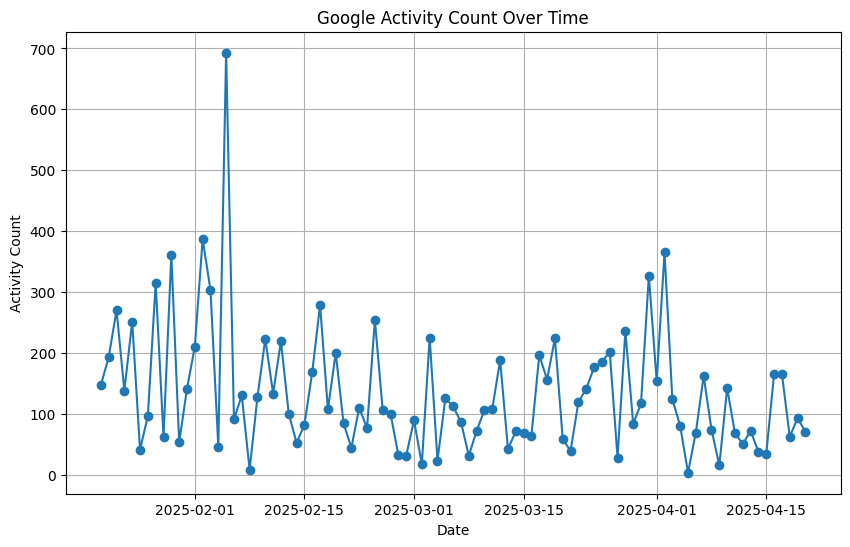

In [111]:
# Plot data
plt.figure(figsize=(10, 6))
plt.plot(filtered_google_activity["Date"], filtered_google_activity["Activity_Count"], marker='o', linestyle='-')
plt.title("Google Activity Count Over Time")
plt.xlabel("Date")
plt.ylabel("Activity Count")
plt.grid(True)
plt.show()


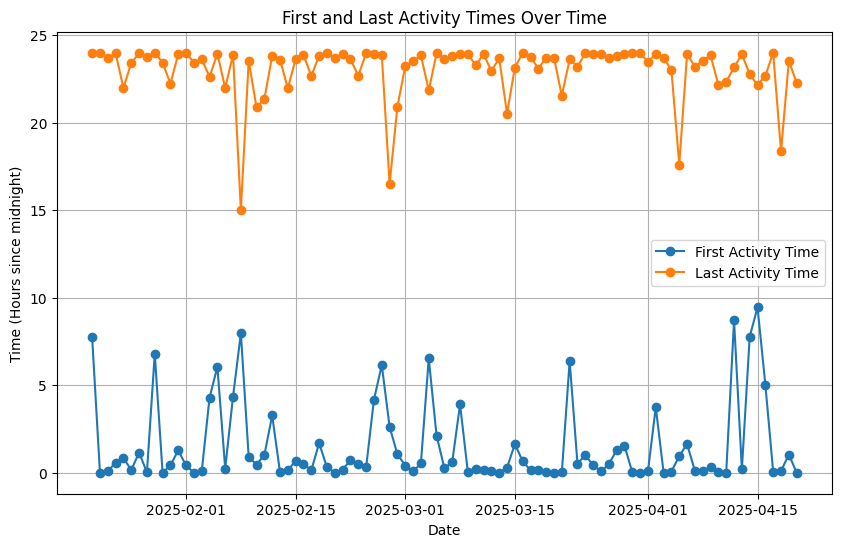

In [113]:
# Plot times
plt.figure(figsize=(10, 6))
plt.plot(filtered_google_activity["Date"],
         [t.hour + t.minute / 60 + t.second / 3600 for t in filtered_google_activity["First_Activity_Time"]],  # Convert datetime.time to numerical representation (hours since midnight)
         marker='o', linestyle='-', label='First Activity Time')
plt.plot(filtered_google_activity["Date"],
         [t.hour + t.minute / 60 + t.second / 3600 for t in filtered_google_activity["Last_Activity_Time"]],  # Convert datetime.time to numerical representation (hours since midnight)
         marker='o', linestyle='-', label='Last Activity Time')
plt.title("First and Last Activity Times Over Time")
plt.xlabel("Date")
plt.ylabel("Time (Hours since midnight)") # Update y-axis label
plt.grid(True)
plt.legend()
plt.show()

---
### Google Calendar Data Preparation

In [114]:
!pip install icalendar


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.4/208.4 kB 3.7 MB/s eta 0:00:00


In [179]:
from datetime import datetime, timezone
import icalendar
from dateutil.rrule import rruleset, rrulestr
import pandas as pd
import re

def fix_rrule_utc(rrule_str):
    """Ensure UNTIL is in UTC format if DTSTART is timezone-aware."""
    match = re.search(r'UNTIL=(\d{8}T?\d*)', rrule_str)
    if match:
        until_raw = match.group(1)
        # Add 'T000000' if date only
        if 'T' not in until_raw:
            until_raw += 'T000000'
        if not until_raw.endswith('Z'):
            rrule_str = rrule_str.replace(f'UNTIL={match.group(1)}', f'UNTIL={until_raw}Z')
    return rrule_str

def infer_event_type(summary, description):
    # Define keyword/phrase lists
    exercise_keywords = ['lift', 'run', 'exercise', 'upper', 'lower', 'pull', 'push', 'speed', 'murph', 'workout']
    academic_keywords = [
        'online behavior for public health', 'responsible ai','rai', 'ai/ml', 'ai','aiml', 'ml',
        'schoolwork', 'school work', 'data privacy', 'school',
        'network security','netsec','presentation','homework','home work','assignment', 'project', 'study',
    ]
    work_keywords = ['work', 'elder research', 'make up work', 'makeup work']
    meals_keywords = ['coffee', 'tea', 'lunch', 'dinner', 'brunch', 'cookout', 'breakfast','cook','meal','eat','food']
    rest_keywords = ['rest','shalom','qt','journal','quiet time','quiettime', 'church', 'sleep', 'nap', 'sarah larsen','psych']

    # Prepare input text
    text = f"{summary or ''} {description or ''}".lower()

    # Helper function to check if any keyword matches as a whole word
    def contains_whole_word(keywords):
        return any(re.search(rf"\b{re.escape(keyword)}\b", text) for keyword in keywords)

    # Check for matches
    if contains_whole_word(exercise_keywords):
        return "exercise"
    elif contains_whole_word(academic_keywords):
        return "academics"
    elif contains_whole_word(work_keywords):
        return "work"
    elif contains_whole_word(meals_keywords):
        return "meals"
    elif contains_whole_word(rest_keywords):
        return "rest"
    else:
        return "other"

def extract_event(component, dt, enddt):
    return {
        "person": "Joseph",
        "date": dt.strftime("%Y-%m-%d"),
        "start_time": dt.strftime("%H:%M"),
        "end_time": enddt.strftime("%H:%M"),
        "duration": int((enddt - dt).total_seconds() / 60),
        "event": component.get('summary'),
        "event_type": infer_event_type(component.get('summary'), component.get('description')),
        "description": None,
    }


def parse_calendar(file_path, range_start, range_end):
    all_events = []

    with open(file_path, 'rb') as f:
        gcal = icalendar.Calendar.from_ical(f.read())

        for component in gcal.walk():
            if component.name != "VEVENT":
                continue

            try:
                startdt = component.get('dtstart').dt
                enddt = component.get('dtend').dt
                if not startdt or not enddt:
                    print(f"Skipping event with missing start or end: {component.get('summary')}")
                    continue
            except AttributeError:
                print(f"Skipping malformed event: {component}")
                continue

            if isinstance(startdt, datetime):
                startdt = startdt.astimezone(timezone.utc)
                enddt = enddt.astimezone(timezone.utc)
            else:
                startdt = datetime.combine(startdt, datetime.min.time()).replace(tzinfo=timezone.utc)
                enddt = datetime.combine(enddt, datetime.min.time()).replace(tzinfo=timezone.utc)

            rrule = component.get('rrule')
            exdate = component.get('exdate')

            if rrule:
                rules = rruleset()
                rrule_str = component.get('rrule').to_ical().decode()
                try:
                    fixed_rrule = fix_rrule_utc(rrule_str)
                    rules.rrule(rrulestr(fixed_rrule, dtstart=startdt))
                except Exception as e:
                    print(f"Error parsing RRULE: {rrule_str} — {e}")
                    continue

                if exdate:
                    exdates = exdate if isinstance(exdate, list) else [exdate]
                    for ex in exdates:
                        for exdt in ex.dts:
                            rules.exdate(exdt.dt.replace(tzinfo=timezone.utc))

                for occ in rules.between(range_start, range_end):
                    duration = enddt - startdt
                    all_events.append(extract_event(component, occ, occ + duration))
            else:
                if range_start <= startdt <= range_end:
                    all_events.append(extract_event(component, startdt, enddt))

    return all_events

# Set your date range and file path
range_start = datetime(2025, 1, 20, tzinfo=timezone.utc)
range_end = datetime(2025, 4, 20, tzinfo=timezone.utc)
ics_path = 'josephowiti7@gmail.com.ics'

# Parse and display
event_list = parse_calendar(ics_path, range_start, range_end)
df = pd.DataFrame(event_list)
print(df.head())

/usr/local/lib/python3.11/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname ZZ identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


Error parsing RRULE: FREQ=WEEKLY;UNTIL=20140725T124500Z;BYDAY=MO,TU,WE,TH,FR — RRULE UNTIL values must be specified in UTC when DTSTART is timezone-aware
Error parsing RRULE: FREQ=WEEKLY;UNTIL=20140807T220000Z;BYDAY=TU,TH — RRULE UNTIL values must be specified in UTC when DTSTART is timezone-aware
Error parsing RRULE: FREQ=WEEKLY;UNTIL=20210623T035959Z;BYDAY=FR,MO,TH,TU,WE;WKST=MO — RRULE UNTIL values must be specified in UTC when DTSTART is timezone-aware
Error parsing RRULE: FREQ=WEEKLY;UNTIL=20210731T035959Z;BYDAY=SA — RRULE UNTIL values must be specified in UTC when DTSTART is timezone-aware
Error parsing RRULE: FREQ=WEEKLY;UNTIL=20210730T035959Z;BYDAY=FR,MO,TH,TU,WE;WKST=MO — RRULE UNTIL values must be specified in UTC when DTSTART is timezone-aware
Error parsing RRULE: FREQ=WEEKLY;UNTIL=20210731T035959Z;BYDAY=SA — RRULE UNTIL values must be specified in UTC when DTSTART is timezone-aware
Error parsing RRULE: FREQ=WEEKLY;UNTIL=20210817T035959Z — RRULE UNTIL values must be specifie

In [180]:
# drop rows where start_time and end_time are both 00:00
df = df[~((df['start_time'] == '00:00') & (df['end_time'] == '00:00'))]

In [182]:
# Write df to csv
df.to_csv('joseph_clean_google_calendar_proj3.csv', index=False)